In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import reloadSimulation
from skimage.feature import register_translation
from scipy import io
from mbptycho.code.recons.recons import DisplacementFullModelReconstruction
import copy
import os
base_path = os.environ['HOME']

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
!pwd

/raid/home/skandel/code/mbptycho/mbptycho/tests/point_inclusions_sparse/weak_peaks


In [6]:
strain_type = 'point_inclusion'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/weak_peaks/'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'

save_plots = False

In [7]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#sim_params={"HKL_list":[[1, 2, 0]]}
sm.sample.Ux_trunc.shape, sm.sample.params.sample_pix_size

File exists. Reloading...


((200, 200, 20), 0.005841818181818182)

## Directly reconstructing the displacements

In [8]:
recons = DisplacementFullModelReconstruction(simulation=sm, shared_magnitudes=True)

Setting background_level to 1e-08...


In [9]:
disp_lr = 1e-2
magnitude_lr = 1e-1
if not 'ux_uy_2d_v' in recons.optimizers:
    recons.setDisplacementAdamOptimizer(disp_lr)
else:
    recons.optimizers['ux_uy_2d_v']['learning_rate'].assign(disp_lr)

if not 'magnitudes_log_v' in recons.optimizers:
    recons.setMagnitudeLogAdamOptimizer(magnitude_lr)
else:
    recons.optimizers['magnitudes_log_v']['learning_rate'].assign(magnitude_lr)

recons.optimizers

{'ux_uy_2d_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.01>,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fb7903c3850>,
  'var': <tf.Variable 'ux_uy:0' shape=(27930,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>},
 'magnitudes_log_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fb7903c3700>,
  'var': <tf.Variable 'magnitudes_log_v:0' shape=(13968,) dtype=float32, numpy=
  array([-16.118095, -16.118095, -16.118095, ..., -16.118095, -16.118095,
         -16.118095], dtype=float32)>}}

In [ ]:
recons.minimize(1000, debug_output_epoch_frequency=1)

        epoch  train_loss     err_ux     err_uy  err_ux_film  err_uy_film   err_rho0   err_rho1   err_rho2   err_rho3  err_rho_film0  err_rho_film1  err_rho_film2  err_rho_film3
54         11    7.93e+04      0.907      0.989        0.895        0.988      0.959      0.967      0.967      0.993           0.96          0.967          0.958          0.993
60         12   6.74e+04       0.92      0.998       0.91      0.998      0.969      0.969      0.974      0.995      0.969      0.972       0.96      0.994
66         13   5.65e+04      0.933      0.998      0.925      0.997      0.975      0.971      0.976      0.995      0.975      0.976      0.963      0.996
72         14   5.01e+04      0.944      0.997      0.938      0.997      0.978      0.974      0.977      0.994      0.979      0.979      0.966      0.995
78         15   4.73e+04      0.956      0.996      0.952      0.996      0.981      0.977      0.979      0.994      0.981       0.98       0.97      0.995
84         16   

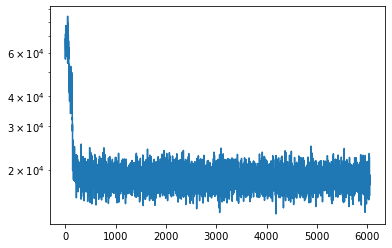

In [22]:
plt.plot(recons.datalog.dataframe.train_loss.dropna())
plt.yscale('log')

In [23]:
recons.uy_2d

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [24]:

true_items = {}
recons_items = {}

if recons._model_type != 'phase':
    recons_items[r"$\alpha_x$"] = recons.ux_2d - recons.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons._ux_true - recons._ux_true.mean() 

    recons_items[r"$\alpha_y$"] = recons.uy_2d - recons.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons._uy_true - recons._uy_true.mean()


if not recons._model_type == 'displacement_to_phase':

    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = register_translation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])

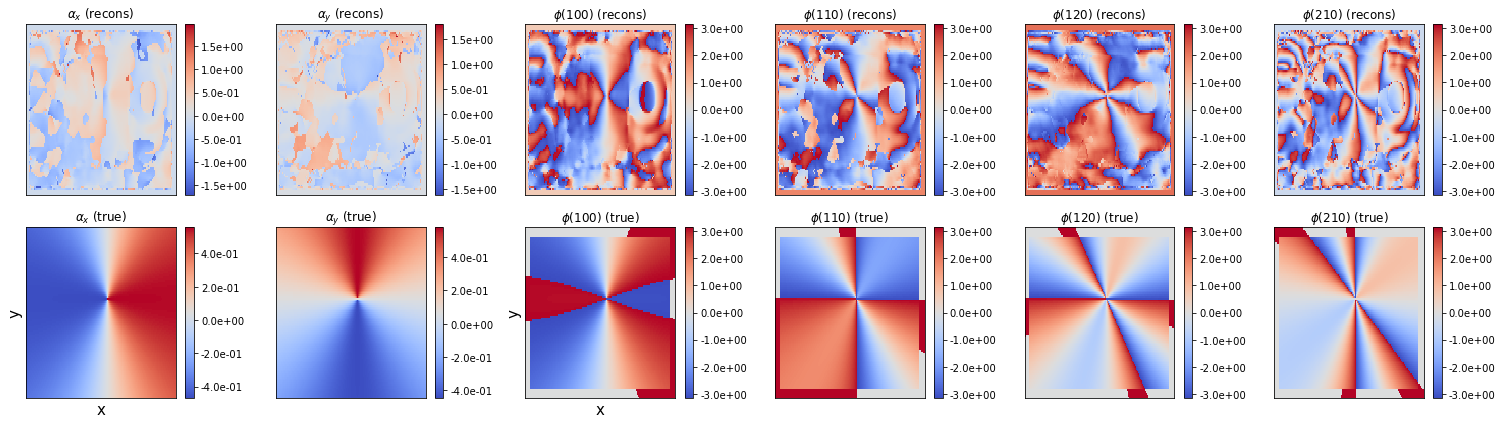

In [25]:
save_plots = False
if recons._model_type == 'phase':
    subplots_x = recons.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons_suffix = recons._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons_items.items()):
    if i == 0 and recons._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

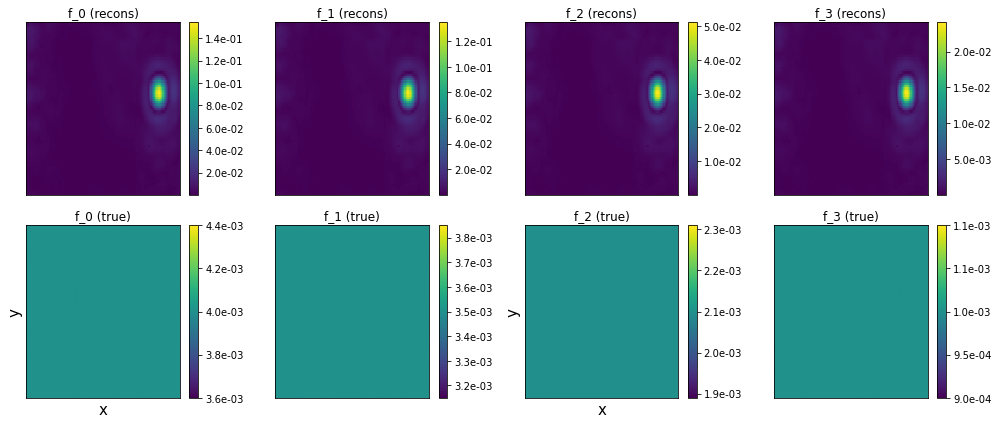

In [26]:
subplots_x = recons.rho_2d.shape[0] 
figsize_x = subplots_x * 3.5

fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 

for i in range(recons.rho_2d.shape[0]):
    recons_amplitudes = np.abs(recons.rho_2d[i][10:-10,10:-10])
    true_amplitudes = np.abs(recons._rho_true[i][10:-10,10:-10])
    
    cp0 = axs[0, i].pcolormesh(recons_amplitudes)
    axs[0, i].set_title(f"f_{i} (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%.1e")
    
    cp1 = axs[1, i].pcolormesh(true_amplitudes)
    axs[1, i].set_title(f"f_{i} (true)")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    plt.colorbar(cp1, ax=axs[1, i], format="%.1e")
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_recons_amplitudes.png', bbox_inches='tight')
plt.show()


In [29]:
recons.saveOutputsAndLog(data_path, prefix='direct_no_projection_')

NameError: name 'recons2_items' is not defined